In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preparación de los datasets

## Cargamos los datasets

In [ ]:
original = pd.read_csv("../data/original.csv")

## METER WEBSCRAPPING?

In [ ]:
train = original.copy()

## Comprobamos los datos

In [4]:
train.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island


In [5]:
train.isna().sum()

Order Date      0
Brand           0
Sneaker Name    0
Sale Price      0
Retail Price    0
Release Date    0
Shoe Size       0
Buyer Region    0
dtype: int64

In [6]:
train.dtypes

Order Date       object
Brand            object
Sneaker Name     object
Sale Price       object
Retail Price     object
Release Date     object
Shoe Size       float64
Buyer Region     object
dtype: object

## Gráficos

Creamos el dataframe df para hacer gráficos sobre el.

In [7]:
df = train.copy()

In [8]:
df['Sale Price'] = df['Sale Price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)
df['Retail Price'] = df['Retail Price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y')
df['Release Date'] = pd.to_datetime(df['Release Date'], format='%m/%d/%y')

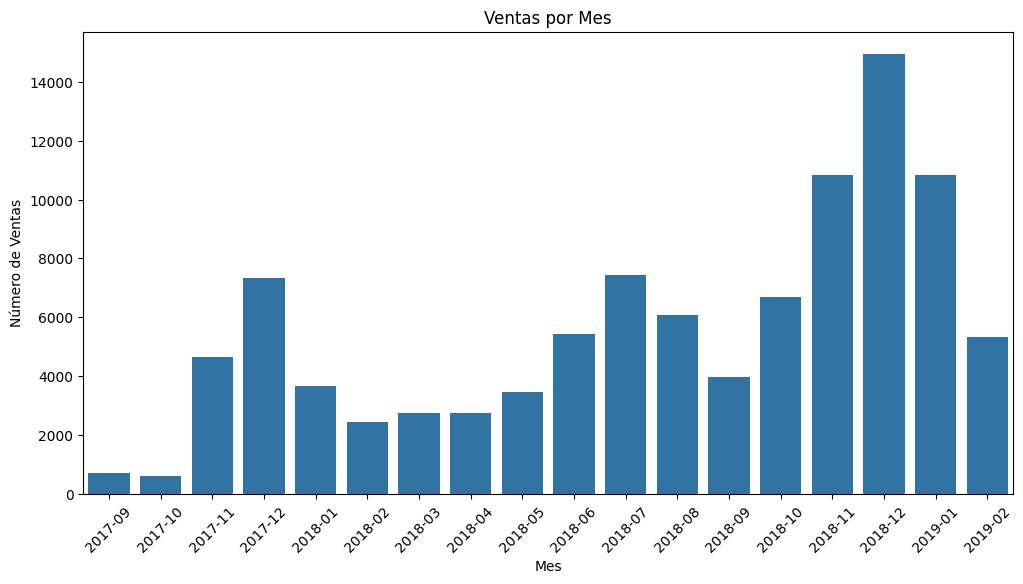

In [9]:
df['Order Month'] = df['Order Date'].dt.to_period('M')

monthly_sales = df['Order Month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_sales.index.astype(str), y=monthly_sales.values)
plt.xticks(rotation=45)
plt.title('Ventas por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Ventas')
plt.show()

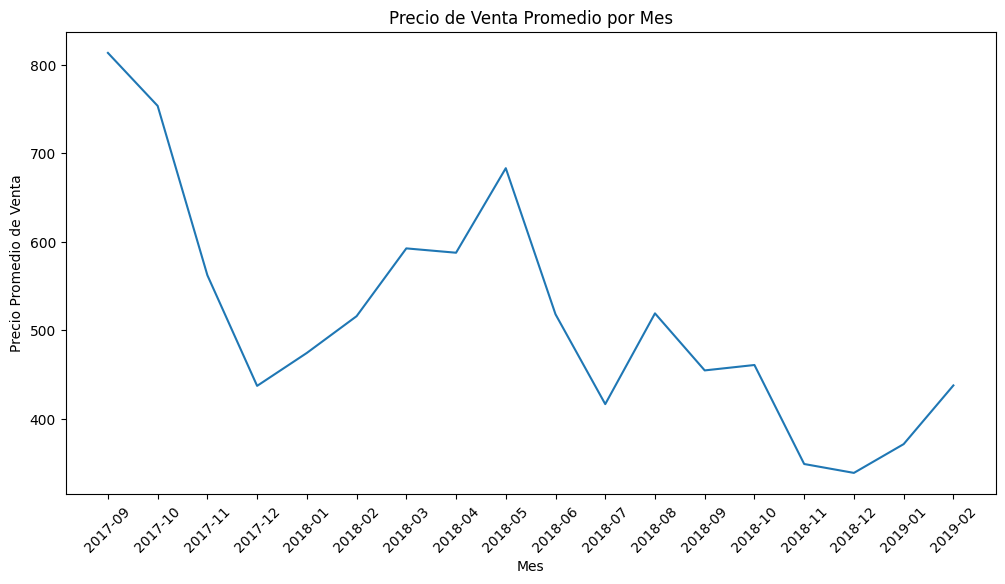

In [10]:
monthly_avg_price = df.groupby('Order Month')['Sale Price'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_avg_price.index.astype(str), y=monthly_avg_price.values)
plt.xticks(rotation=45)
plt.title('Precio de Venta Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Precio Promedio de Venta')
plt.show()

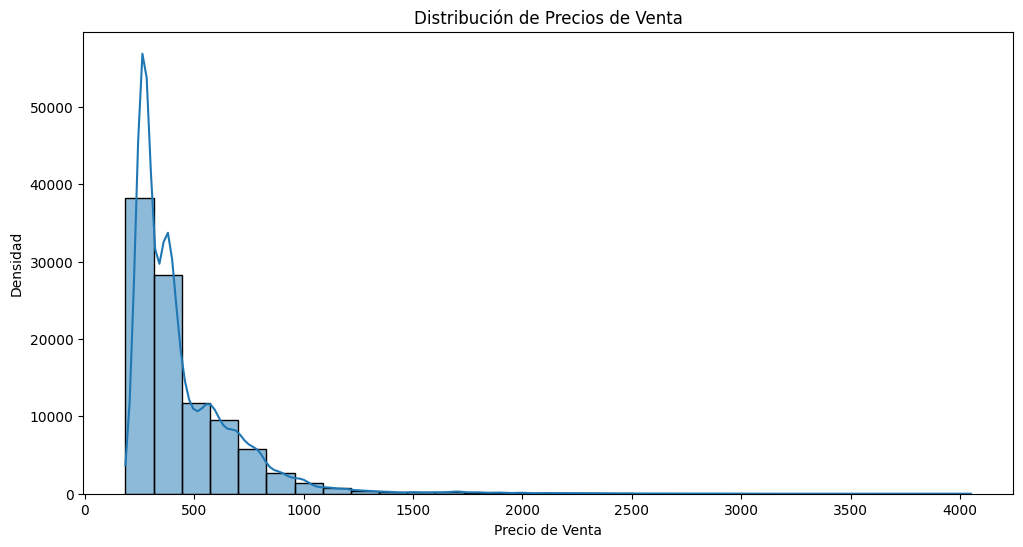

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Sale Price'], bins=30, kde=True)
plt.title('Distribución de Precios de Venta')
plt.xlabel('Precio de Venta')
plt.ylabel('Densidad')
plt.show()

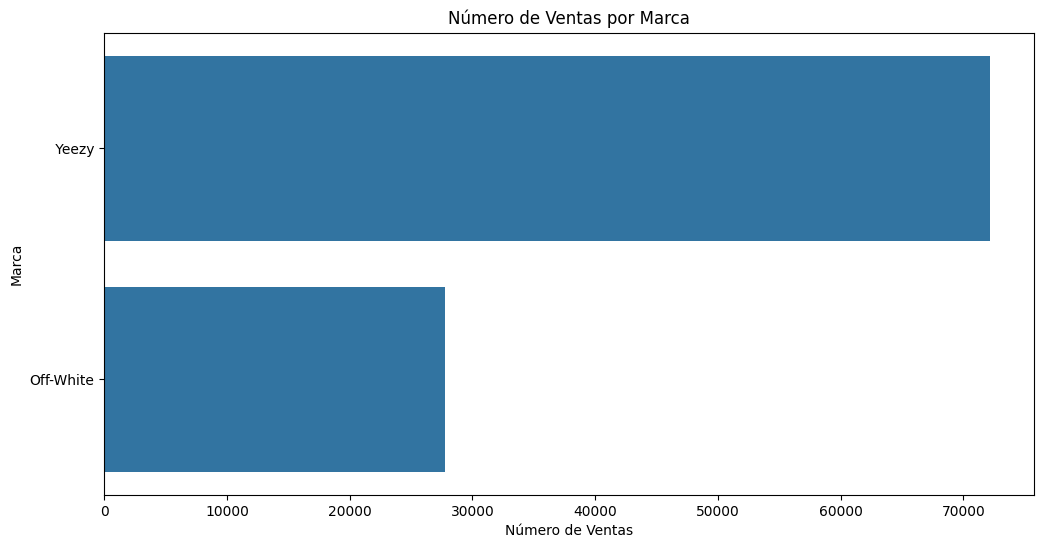

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Brand', data=df, order=df['Brand'].value_counts().index)
plt.title('Número de Ventas por Marca')
plt.xlabel('Número de Ventas')
plt.ylabel('Marca')
plt.show()

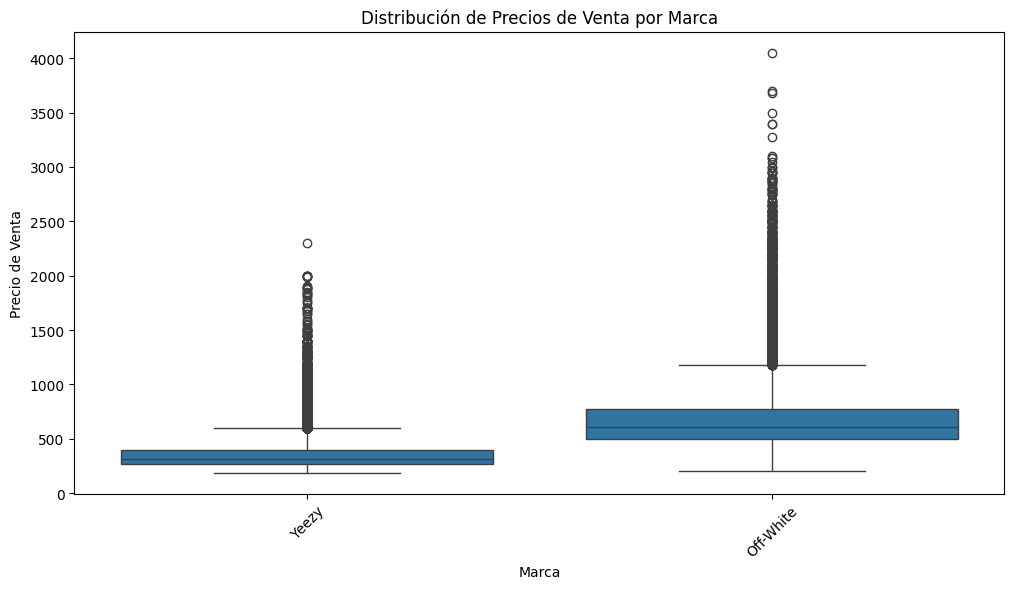

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Brand', y='Sale Price', data=df)
plt.title('Distribución de Precios de Venta por Marca')
plt.xticks(rotation=45)
plt.xlabel('Marca')
plt.ylabel('Precio de Venta')
plt.show()

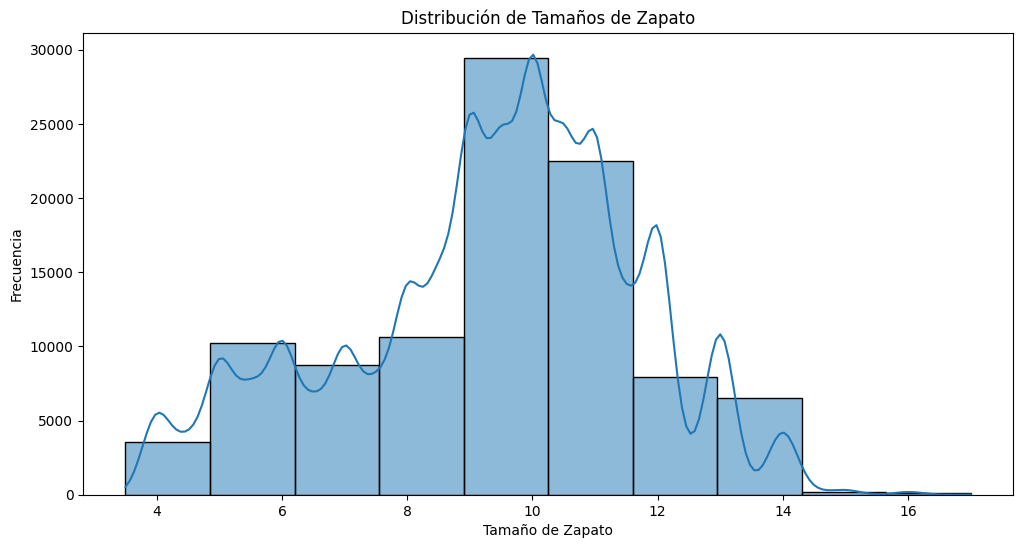

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Shoe Size'], bins=10, kde=True)
plt.title('Distribución de Tamaños de Zapato')
plt.xlabel('Tamaño de Zapato')
plt.ylabel('Frecuencia')
plt.show()

## Limpiamos el dataset

In [15]:
def clean_dataset(data, dtype):
    #categorical_cols = ['Brand', 'Sneaker Name', 'Release Date', 'Buyer Region']
    categorical_cols = ['Brand', 'Sneaker Name', 'Buyer Region']
    #numerical_cols = ['Sale Price', 'Retail Price', 'Shoe Size', 'Order Date']
    numerical_cols = ['Sale Price', 'Retail Price', 'Shoe Size']
    if dtype != "test":
        numerical_cols.remove("Sale Price")

    # Precios
    data['Sale Price'] = data['Sale Price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)
    data['Retail Price'] = data['Retail Price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

    # Fechas
    data['Order Date'] = pd.to_datetime(data['Order Date'], format='%m/%d/%y')
    data['Release Date'] = pd.to_datetime(data['Release Date'], format='%m/%d/%y')

    data['Order Year'] = data['Order Date'].dt.year
    data['Order Month'] = data['Order Date'].dt.month
    data['Order Day'] = data['Order Date'].dt.day
    data['Order Day of Week'] = data['Order Date'].dt.dayofweek
    
    data['Release Year'] = data['Release Date'].dt.year
    data['Release Month'] = data['Release Date'].dt.month
    data['Release Day'] = data['Release Date'].dt.day
    data['Release Day of Week'] = data['Release Date'].dt.dayofweek
    
    data['Order Date'] = data['Order Date'].astype(np.int64) // 10**9
    data['Release Date'] = data['Release Date'].astype(np.int64) // 10**9


    # Variables Categóricas
    data = pd.get_dummies(data, columns=categorical_cols)

    # Variables Numéricas
    scaler = StandardScaler()
    scaler.fit(df[numerical_cols])
    data[numerical_cols] = scaler.transform(data[numerical_cols])
    return data

In [16]:
train1 = clean_dataset(train.copy(), "train")
X = train1.loc[:, train1.columns != "Sale Price"]
y = train1.loc[:, "Sale Price"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine Learning

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
def calculate_train_val(clf, X_train, y_train, X_val, y_val):
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    print("--------------------------------------------\n", clf, "\n--------------------------------------------")
    print("Train RMSLE:", np.sqrt(mean_squared_error(np.log(y_train), np.log(y_train_pred))))
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
    print("Train R^2:", r2_score(y_train, y_train_pred), "\n")
    y_val_pred = clf.predict(X_val) 
    print("Validation RMSLE:", np.sqrt(mean_squared_error(np.log(y_val), np.log(y_val_pred))))
    print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
    print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
    print("Validation R^2:", r2_score(y_val, y_val_pred))

In [19]:
clf = GradientBoostingRegressor()

In [20]:
calculate_train_val(clf, X_train, y_train, X_val, y_val)

--------------------------------------------
 GradientBoostingRegressor() 
--------------------------------------------
Train RMSLE: 0.13303571554844723
Train RMSE: 77.42815178879948
Train MAE: 48.14440739034766
Train R^2: 0.908807755621422 

Validation RMSLE: 0.13568644590784282
Validation RMSE: 79.8454840217785
Validation MAE: 49.783468186616176
Validation R^2: 0.9013994590006591


In [21]:
low_index = 250
high_index = 450

In [22]:
global_model = GradientBoostingRegressor()
global_model.fit(X_train, y_train)


low_price_model = GradientBoostingRegressor()
mid_price_model = GradientBoostingRegressor()
high_price_model = GradientBoostingRegressor()

# Filtramos y entrenamos cada modelo especializado
low_price_data = train1[train1['Sale Price'] < low_index]
mid_price_data = train1[(train1['Sale Price'] >= low_index) & (train1['Sale Price'] <= high_index)]
high_price_data = train1[train1['Sale Price'] > high_index]

features = [col for col in low_price_data.columns if col != "Sale Price"]
low_price_model.fit(low_price_data[features], low_price_data['Sale Price'])
mid_price_model.fit(mid_price_data[features], mid_price_data['Sale Price'])
high_price_model.fit(high_price_data[features], high_price_data['Sale Price'])

GradientBoostingRegressor()

In [23]:
def predict_with_specialized_models(X):
    predicted_prices = global_model.predict(X)
    
    final_predictions = np.zeros(len(X))
    
    low_price_indices = np.where(predicted_prices < low_index)
    if len(low_price_indices[0]) > 0:
        final_predictions[low_price_indices] = low_price_model.predict(X.iloc[low_price_indices])

    mid_price_indices = np.where((predicted_prices >= low_index) & (predicted_prices <= high_index))
    if len(mid_price_indices[0]) > 0:
        final_predictions[mid_price_indices] = mid_price_model.predict(X.iloc[mid_price_indices])
    
    high_price_indices = np.where(predicted_prices > high_index)
    if len(high_price_indices[0]) > 0:
        final_predictions[high_price_indices] = high_price_model.predict(X.iloc[high_price_indices])
    
    return predicted_prices, final_predictions
    
y_val_pred, y_val_pred1 = predict_with_specialized_models(X_val)

print("Predicciones con todo el dataset")
print("Validation RMSLE:", np.sqrt(mean_squared_error(np.log(y_val), np.log(y_val_pred))))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("Validation R^2:", r2_score(y_val, y_val_pred))
print("----------------------------------------------------------------------------------------")
print("Predicciones con el dataset dividido")
print("Validation RMSLE:", np.sqrt(mean_squared_error(np.log(y_val), np.log(y_val_pred1))))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred1)))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred1))
print("Validation R^2:", r2_score(y_val, y_val_pred1))

Predicciones con todo el dataset
Validation RMSLE: 0.13568644590784254
Validation RMSE: 79.8454840217784
Validation MAE: 49.78346818661606
Validation R^2: 0.9013994590006593
----------------------------------------------------------------------------------------
Predicciones con el dataset dividido
Validation RMSLE: 0.11471132526204349
Validation RMSE: 70.4254916784737
Validation MAE: 39.92060685424548
Validation R^2: 0.9232924066231686
